In [1]:
import pandas as pd
import numpy as np

## Data Integration

In [2]:
df_data = pd.read_excel("Assignment_Data.xlsx")
My_df = df_data.copy()
My_df.head()


,property_address,property_suburb,property_state,listing_description,listed_date,listed_price,days_on_market,number_of_beds,number_of_baths,number_of_parks,property_size,property_classification,property_sub_classification,suburb_days_on_market,suburb_median_price,price_outcome
0,"10/15 Childs Street, CLAYFIELD QLD 4011",CLAYFIELD,QLD,Living Among the Tree Tops! Enjoy the cooling ...,2022-03-24,475000,6,2,2.0,1.0,NaN,Unit,Apartment / Unit / Flat,NaN,NaN,Higher
1,"7 Oudeman Street, AUGUSTINE HEIGHTS QLD 4300",AUGUSTINE HEIGHTS,QLD,Poised To Impress This immaculate residence wi...,2022-06-16,899000,47,4,2.0,2.0,740.0,House,House,NaN,NaN,Lower
2,"37 Starling Street, DEEBING HEIGHTS QLD 4306",DEEBING HEIGHTS,QLD,Affordable & Stylish This welcoming 4 Bedroom ...,2022-10-13,579000,25,4,2.0,2.0,398.0,House,House,NaN,NaN,Higher
3,"32 Horizon Drive, JAMBOREE HEIGHTS QLD 4074",JAMBOREE HEIGHTS,QLD,FULLY RENOVATED LOW SET FAMILY HOME This stunn...,2022-07-31,800000,36,4,2.0,1.0,607.0,House,House,NaN,NaN,Higher
4,"90 Lunga Street, CARINA QLD 4152",CARINA,QLD,Renovated family home on 607sqm in leafy sough...,2022-10-13,889000,20,3,1.0,1.0,607.0,House,House,28.0,913000.0,Lower


## Number of Rows and Features in the Dataset

In [3]:
My_df.shape

(6957, 16)

## Checking for missing values

In [4]:
My_df.isnull().sum()

property_address                  0
property_suburb                   0
property_state                    0
listing_description               0
listed_date                       0
listed_price                      0
days_on_market                    0
number_of_beds                    0
number_of_baths                 163
number_of_parks                 191
property_size                  1907
property_classification           0
property_sub_classification       0
suburb_days_on_market          6185
suburb_median_price            6043
price_outcome                     0
dtype: int64

## Delete rows with missing (null) values and reset index

In [5]:
# Filling nulls with mean values 
My_df['number_of_baths'] = My_df['number_of_baths'].fillna(My_df['number_of_baths'].mean())
My_df['number_of_parks'] = My_df['number_of_parks'].fillna(My_df['number_of_parks'].mean())
My_df['property_size'] = My_df['property_size'].fillna(My_df['property_size'].mean())

# Best to drop when 87–89% data missing, would be risky and could potentially mislead the model
My_df.drop(columns=['suburb_days_on_market', 'suburb_median_price'], inplace=True)


# Filter to keep only 'Higher' and 'Lower'
My_df = My_df[My_df['price_outcome'].isin(['Higher', 'Lower'])].copy()



In [6]:
My_df.isnull().sum()

property_address               0
property_suburb                0
property_state                 0
listing_description            0
listed_date                    0
listed_price                   0
days_on_market                 0
number_of_beds                 0
number_of_baths                0
number_of_parks                0
property_size                  0
property_classification        0
property_sub_classification    0
price_outcome                  0
dtype: int64

## Checking the Datatypes in the Dataset

In [7]:
My_df.dtypes

property_address                       object
property_suburb                        object
property_state                         object
listing_description                    object
listed_date                    datetime64[ns]
listed_price                            int64
days_on_market                          int64
number_of_beds                          int64
number_of_baths                       float64
number_of_parks                       float64
property_size                         float64
property_classification                object
property_sub_classification            object
price_outcome                          object
dtype: object

## Convert text to numerical

In [8]:
# One-hot encoding & Removal features

categorical_columns = [
    'property_suburb',
    'property_state',
    'property_classification',
    'property_sub_classification'
]

available_columns = [col for col in categorical_columns if col in My_df.columns]
My_df = pd.get_dummies(My_df, columns=available_columns, drop_first=True)

#Removing features that are not necessary for target variable prediction
My_df.drop(columns=['property_address'], inplace=True, errors='ignore')
My_df.drop(columns=['listed_date'], inplace=True, errors = 'ignore')

In [9]:
My_df.dtypes

listing_description                         object
listed_price                                 int64
days_on_market                               int64
number_of_beds                               int64
number_of_baths                            float64
                                            ...   
property_sub_classification_Studio            bool
property_sub_classification_Terrace           bool
property_sub_classification_Townhouse         bool
property_sub_classification_Vacant land       bool
property_sub_classification_Villa             bool
Length: 253, dtype: object

## NLP - Text Processing


In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Downloaded required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Applying text preprocessing
My_df['cleaned_description'] = My_df['listing_description'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(My_df['cleaned_description'])

# SVD Dimensionality Reduction
svd = TruncatedSVD(n_components=5, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

# Adding SVD components to My_df
svd_columns = [f'SVD{i+1}' for i in range(5)]
df_svd = pd.DataFrame(X_svd, columns=svd_columns, index=My_df.index)
My_df = pd.concat([My_df, df_svd], axis=1)

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
My_df['Sentiment'] = My_df['listing_description'].apply(lambda x: sia.polarity_scores(str(x))['compound'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elleonoraradulovic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elleonoraradulovic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elleonoraradulovic/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/elleonoraradulovic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
My_df.head()

,listing_description,listed_price,days_on_market,number_of_beds,number_of_baths,number_of_parks,property_size,price_outcome,property_suburb_ALBANY CREEK,property_suburb_ALBION,...,property_sub_classification_Townhouse,property_sub_classification_Vacant land,property_sub_classification_Villa,cleaned_description,SVD1,SVD2,SVD3,SVD4,SVD5,Sentiment
0,Living Among the Tree Tops! Enjoy the cooling ...,475000,6,2,2.0,1.0,743.649307,Higher,False,False,...,False,False,False,living among tree top enjoy cooling effect lus...,0.292185,0.112806,-0.044445,0.019134,0.012878,0.9277
1,Poised To Impress This immaculate residence wi...,899000,47,4,2.0,2.0,740.000000,Lower,False,False,...,False,False,False,poised impress immaculate residence beautifull...,0.403392,-0.129449,0.429139,-0.158711,-0.127981,0.9464
2,Affordable & Stylish This welcoming 4 Bedroom ...,579000,25,4,2.0,2.0,398.000000,Higher,False,False,...,False,False,False,affordable stylish welcoming bedroom home feat...,0.584441,-0.177776,-0.001786,-0.044148,0.018258,0.9924
3,FULLY RENOVATED LOW SET FAMILY HOME This stunn...,800000,36,4,2.0,1.0,607.000000,Higher,False,False,...,False,False,False,fully renovated low set family home stunning l...,0.480857,-0.165081,-0.068099,0.078937,0.041028,0.9863
4,Renovated family home on 607sqm in leafy sough...,889000,20,3,1.0,1.0,607.000000,Lower,False,False,...,False,False,False,renovated family home sqm leafy soughtafter ca...,0.514257,-0.036391,0.030954,0.284729,-0.149504,0.9951


In [12]:
 # Implementing the concept of a Dictionary (a mapping between words and their integer ids):
from gensim import corpora

texts = My_df['cleaned_description'].apply(str.split)
My_id2word = corpora.Dictionary(texts)

#Converting document (a list of words) into the BOW format:
My_Corpus = [My_id2word.doc2bow(text) for text in texts]

#Building LDA model:
from gensim import models
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=4, random_state= 0)
My_LDA.print_topics()



[(0,
  '0.016*"home" + 0.011*"living" + 0.009*"bedroom" + 0.009*"property" + 0.009*"area" + 0.008*"space" + 0.007*"family" + 0.006*"school" + 0.006*"room" + 0.005*"kitchen"'),
 (1,
  '0.012*"home" + 0.010*"property" + 0.010*"bedroom" + 0.009*"area" + 0.008*"living" + 0.007*"family" + 0.006*"feature" + 0.006*"space" + 0.006*"brisbane" + 0.005*"offer"'),
 (2,
  '0.019*"home" + 0.011*"area" + 0.011*"bedroom" + 0.010*"living" + 0.008*"family" + 0.008*"kitchen" + 0.007*"space" + 0.007*"property" + 0.007*"school" + 0.006*"feature"'),
 (3,
  '0.015*"home" + 0.013*"bedroom" + 0.009*"property" + 0.009*"area" + 0.009*"living" + 0.008*"family" + 0.007*"large" + 0.007*"kitchen" + 0.007*"school" + 0.006*"space"')]

In [13]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=My_LDA, corpus=My_Corpus, texts=texts, dictionary=My_id2word, coherence='u_mass')
coherence = cm.get_coherence() 

#Visualising topic Coherence (k number of topics):
k = 4
LDA_cm = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=k, random_state= 0)
cm = CoherenceModel(model=LDA_cm, corpus=My_Corpus, texts=texts, dictionary=My_id2word, coherence='u_mass')
print(cm.get_coherence())

# Identifying topic probabilities:
topic_probabilities = list(My_LDA.get_document_topics(bow=My_Corpus, minimum_probability=0.0))
list(topic_probabilities)[0:5]

extracted_probabilities = []
for row in topic_probabilities:
    row_probabilities = [prob for _, prob in row]  # each row should have 4 values
    extracted_probabilities.append(row_probabilities)

# Identifying the most probable topic:
most_probable = [prob.index(max(prob)) for prob in extracted_probabilities]

# Adding probabilities to dataframe:
My_df[['Topic1', 'Topic2', 'Topic3', 'Topic4']] = extracted_probabilities
My_df['Probable_Topic'] = most_probable

-0.6328665833631424


In [14]:
My_df.head()

,listing_description,listed_price,days_on_market,number_of_beds,number_of_baths,number_of_parks,property_size,price_outcome,property_suburb_ALBANY CREEK,property_suburb_ALBION,...,SVD2,SVD3,SVD4,SVD5,Sentiment,Topic1,Topic2,Topic3,Topic4,Probable_Topic
0,Living Among the Tree Tops! Enjoy the cooling ...,475000,6,2,2.0,1.0,743.649307,Higher,False,False,...,0.112806,-0.044445,0.019134,0.012878,0.9277,0.402347,0.352729,0.242332,0.002592,0
1,Poised To Impress This immaculate residence wi...,899000,47,4,2.0,2.0,740.000000,Lower,False,False,...,-0.129449,0.429139,-0.158711,-0.127981,0.9464,0.047902,0.001988,0.819013,0.131097,2
2,Affordable & Stylish This welcoming 4 Bedroom ...,579000,25,4,2.0,2.0,398.000000,Higher,False,False,...,-0.177776,-0.001786,-0.044148,0.018258,0.9924,0.004945,0.000810,0.541679,0.452566,2
3,FULLY RENOVATED LOW SET FAMILY HOME This stunn...,800000,36,4,2.0,1.0,607.000000,Higher,False,False,...,-0.165081,-0.068099,0.078937,0.041028,0.9863,0.014406,0.001343,0.456777,0.527474,3
4,Renovated family home on 607sqm in leafy sough...,889000,20,3,1.0,1.0,607.000000,Lower,False,False,...,-0.036391,0.030954,0.284729,-0.149504,0.9951,0.047493,0.025086,0.055128,0.872293,3


In [15]:
from sklearn.preprocessing import LabelEncoder

# Drop unused columns
drop_cols = ['price_outcome', 'listing_description', 'cleaned_description']
X = My_df.drop(columns=drop_cols, errors='ignore')

# Encode target (binary: 1 for 'Higher', 0 for 'Lower')
le = LabelEncoder()
y = le.fit_transform(My_df['price_outcome'])

## Baseline SVM Model (No Cross-Validation)

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report
)
import pandas as pd

# Step 1: Prepare features and target
drop_cols = ['price_outcome', 'listing_description', 'cleaned_description']
X = My_df.drop(columns=drop_cols, errors='ignore')

le = LabelEncoder()
y = le.fit_transform(My_df['price_outcome'])  # 1 = 'Higher', 0 = 'Lower'

# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Create and fit pipeline
my_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])
my_svm_pipeline.fit(X_train, y_train)

# Step 4: Predict
y_pred = my_svm_pipeline.predict(X_test)
y_proba = my_svm_pipeline.predict_proba(X_test)[:, 1]

# Step 5: Format results
results_svm_nocv = pd.Series({
    'test_accuracy': accuracy_score(y_test, y_pred),
    'test_recall': recall_score(y_test, y_pred, zero_division=0),
    'test_precision': precision_score(y_test, y_pred, zero_division=0),
    'test_f1': f1_score(y_test, y_pred, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test, y_proba)
})

print("=== SVM (No Cross-Validation) Results ===")
print(results_svm_nocv.round(4))

=== SVM (No Cross-Validation) Results ===
test_accuracy     0.6331
test_recall       0.2658
test_precision    0.5000
test_f1           0.3471
test_roc_auc      0.6783
dtype: float64


## SVM with Cross-Validation

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Step 1: Prepare features and target
drop_cols = ['price_outcome', 'listing_description', 'cleaned_description']
X = My_df.drop(columns=drop_cols, errors='ignore')

le = LabelEncoder()
y = le.fit_transform(My_df['price_outcome'])  # 1 = 'Higher', 0 = 'Lower'

# Step 2: Create SVM pipeline (with scaling)
my_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# Step 3: Perform cross-validation with multiple metrics
scores_svc = cross_validate(
    my_svm_pipeline, X, y,
    cv=5,
    scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'],
    return_train_score=False
)

# Step 4: Format results as a Series
results_svc = pd.Series(pd.DataFrame(scores_svc).mean())
print("=== SVM (Cross-Validated) Results ===")
print(results_svc.round(4))

=== SVM (Cross-Validated) Results ===
fit_time          13.3547
score_time         1.7509
test_accuracy      0.6442
test_recall        0.2393
test_precision     0.5380
test_f1            0.3302
test_roc_auc       0.6926
dtype: float64


## SVM - Effect of C on Model Performance

In [18]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Prepare data
drop_cols = ['price_outcome', 'listing_description', 'cleaned_description']
X = My_df.drop(columns=drop_cols, errors='ignore')
le = LabelEncoder()
y = le.fit_transform(My_df['price_outcome'])

# 2. C values to test
C_values = [0.1, 1, 10, 100, 1000, 10000]

# 3. Store results
results_no_cv = []
results_cv = []

# 4. Loop over C values
for c in C_values:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=c, gamma='scale', probability=True, random_state=42))
    ])

    # --- Without cross-validation ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    results_no_cv.append({
        'C': c,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

    # --- With cross-validation ---
    scores = cross_validate(
        pipeline, X, y,
        cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        return_train_score=False
    )

    results_cv.append({
        'C': c,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1': np.mean(scores['test_f1']),
        'ROC_AUC': np.mean(scores['test_roc_auc'])
    })

# Convert to DataFrames
df_no_cv = pd.DataFrame(results_no_cv)
df_cv = pd.DataFrame(results_cv)

# Preview
print("=== Without Cross-Validation ===")
print(df_no_cv.round(4))

print("\n=== With Cross-Validation ===")
print(df_cv.round(4))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

=== Without Cross-Validation ===
         C  Accuracy  Precision  Recall      F1  ROC_AUC
0      0.1    0.6331     0.0000  0.0000  0.0000   0.6666
1      1.0    0.6331     0.5000  0.2658  0.3471   0.6783
2     10.0    0.7074     0.6422  0.4575  0.5344   0.7382
3    100.0    0.7514     0.6841  0.5991  0.6388   0.7844
4   1000.0    0.7922     0.7236  0.7015  0.7124   0.8061
5  10000.0    0.8074     0.7329  0.7473  0.7400   0.8044

=== With Cross-Validation ===
         C  Accuracy  Precision  Recall      F1  ROC_AUC
0      0.1    0.6329     0.0000  0.0000  0.0000   0.6795
1      1.0    0.6442     0.5380  0.2393  0.3302   0.6926
2     10.0    0.6940     0.6186  0.4377  0.5119   0.7427
3    100.0    0.7535     0.6798  0.6203  0.6487   0.7898
4   1000.0    0.7960     0.7205  0.7258  0.7231   0.8160
5  10000.0    0.8159     0.7363  0.7764  0.7557   0.8224


# Plotting the results

## Plot 1: Without Cross-Validation

In [19]:
import matplotlib.pyplot as plt
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']

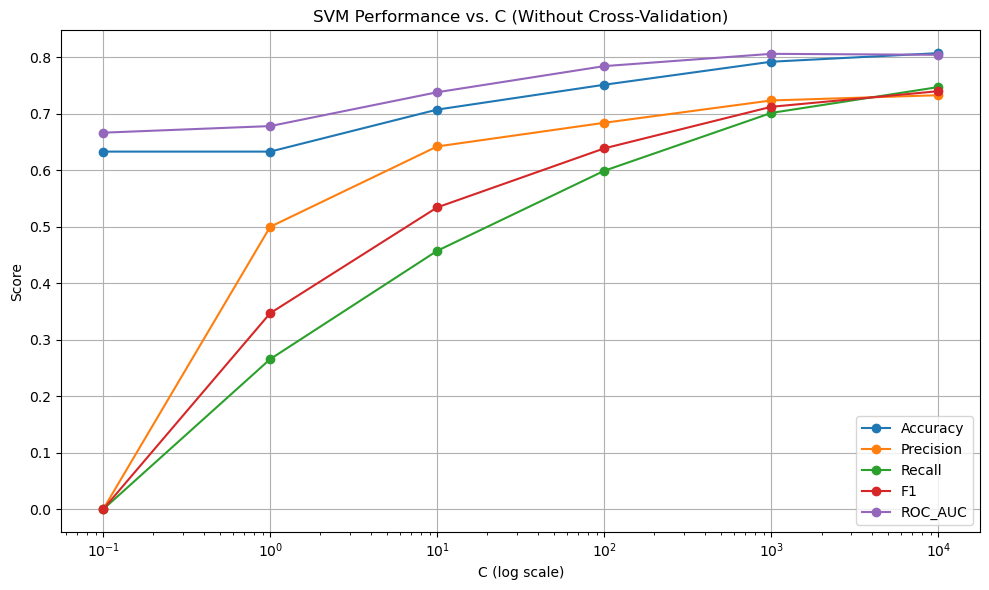

In [20]:
# === Plot 1: Without Cross-Validation ===
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(df_no_cv['C'], df_no_cv[metric], marker='o', label=metric)
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Score')
plt.title('SVM Performance vs. C (Without Cross-Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 2: With Cross-Validation

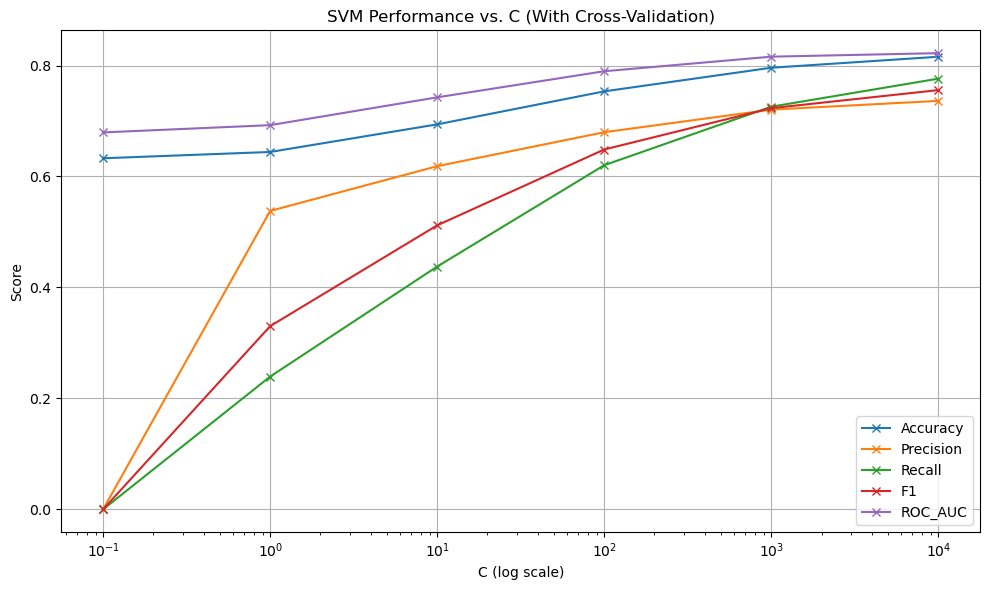

In [21]:
# === Plot 2: With Cross-Validation ===
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(df_cv['C'], df_cv[metric], marker='x', label=metric)
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Score')
plt.title('SVM Performance vs. C (With Cross-Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Confusion Matric C= 10000 with cross-validation

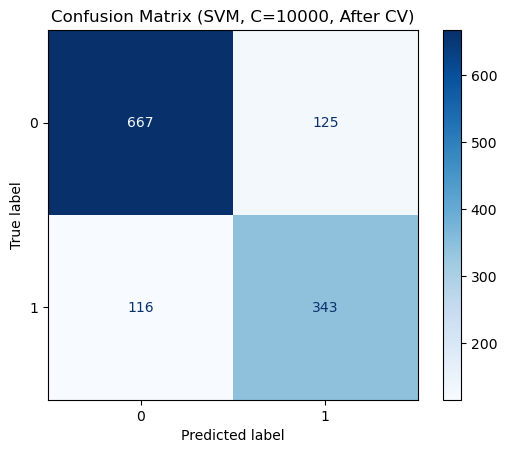

In [22]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split data again (or reuse from above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SVM pipeline with cross-validated best C = 10000
my_svm_pipeline_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10000, gamma='scale', probability=True, random_state=42))
])

# Fit on training data (after CV)
my_svm_pipeline_cv.fit(X_train, y_train)
y_pred_cv = my_svm_pipeline_cv.predict(X_test)

# Confusion matrix
cm_cv = confusion_matrix(y_test, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv)
disp_cv.plot(cmap='Blues')
plt.title("Confusion Matrix (SVM, C=10000, After CV)")
plt.show()

## Confusion Matrix with C = 1.0 with cross validation

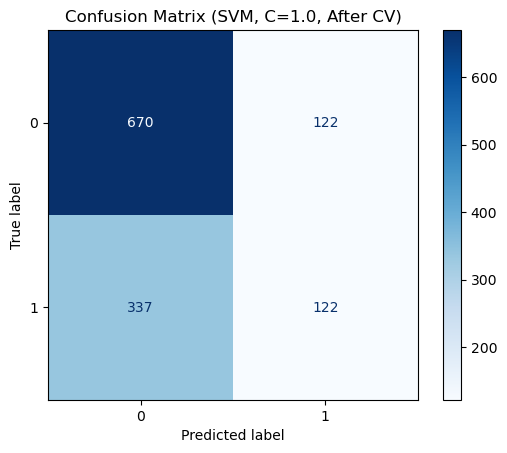

In [23]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split data again (or reuse from above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SVM pipeline with cross-validated best C = 1.0
my_svm_pipeline_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
])

# Fit on training data (after CV)
my_svm_pipeline_cv.fit(X_train, y_train)
y_pred_cv = my_svm_pipeline_cv.predict(X_test)

# Confusion matrix
cm_cv = confusion_matrix(y_test, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv)
disp_cv.plot(cmap='Blues')
plt.title("Confusion Matrix (SVM, C=1.0, After CV)")
plt.show()

In [24]:
import pandas as pd

# Define evaluation metrics
metrics_table = pd.DataFrame({
    "Model": ["SVM (C = 1.0, CV)", 
              "SVM (C = 10000, CV)"],
    "Accuracy": [0.6442, 0.8159],
    "Precision": [0.5380, 0.7363],
    "Recall": [0.2393, 0.7764],
    "F1-Score": [0.3302, 0.7557],
    "ROC AUC": [0.6926, 0.8224]
})

# Show the table nicely
metrics_table

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,"SVM (C = 1.0, CV)",0.6442,0.5380,0.2393,0.3302,0.6926
1,"SVM (C = 10000, CV)",0.8159,0.7363,0.7764,0.7557,0.8224


## Random Forest: 

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt


## Random Forest Without Cross-Validation (Varying max_depth)

In [26]:

# Prepare your data (assuming you already have `X` and `y`)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

depths = [2, 4, 6, 8, 10, 12, 15]
results_rf_no_cv = []

for depth in depths:
    my_RFC = RandomForestClassifier(max_depth=depth, random_state=42)
    my_RFC.fit(X_train, y_train)
    y_pred = my_RFC.predict(X_test)

    results_rf_no_cv.append({
        "max_depth": depth,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted'),
        "recall": recall_score(y_test, y_pred, average='weighted'),
        "f1": f1_score(y_test, y_pred, average='weighted')
    })

# Convert to DataFrame for easy viewing/plotting
import pandas as pd
df_rf_no_cv = pd.DataFrame(results_rf_no_cv)
display(df_rf_no_cv)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,max_depth,accuracy,precision,recall,f1
0,2,0.633094,0.400807,0.633094,0.490857
1,4,0.633893,0.768035,0.633893,0.492692
2,6,0.646683,0.754070,0.646683,0.522472
3,8,0.653078,0.705518,0.653078,0.544281
4,10,0.685851,0.749204,0.685851,0.608287
5,12,0.704237,0.745626,0.704237,0.646739
6,15,0.754596,0.790206,0.754596,0.721971


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


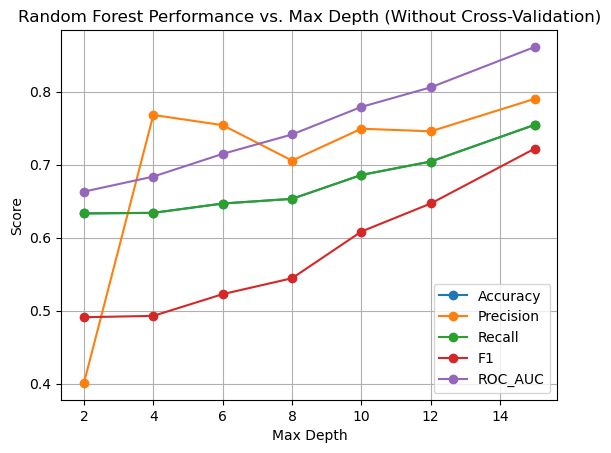

In [27]:
from sklearn.metrics import roc_auc_score

depths = [2, 4, 6, 8, 10, 12, 15]
rf_no_cv_metrics = {
    "max_depth": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "ROC_AUC": []
}

for depth in depths:
    my_RFC = RandomForestClassifier(max_depth=depth, random_state=42)
    my_RFC.fit(X_train, y_train)
    y_pred = my_RFC.predict(X_test)
    y_proba = my_RFC.predict_proba(X_test)

    rf_no_cv_metrics["max_depth"].append(depth)
    rf_no_cv_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    rf_no_cv_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
    rf_no_cv_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
    rf_no_cv_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))

    # ROC AUC: only if more than 1 class and probabilities available
    if len(np.unique(y)) == 2:
        rf_no_cv_metrics["ROC_AUC"].append(roc_auc_score(y_test, y_proba[:, 1]))
    else:
        rf_no_cv_metrics["ROC_AUC"].append(roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'))

# Plot
import matplotlib.pyplot as plt

plt.figure()
for metric in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
    plt.plot(rf_no_cv_metrics["max_depth"], rf_no_cv_metrics[metric], marker='o', label=metric)
plt.xlabel("Max Depth")
plt.xscale("linear")
plt.ylabel("Score")
plt.title("Random Forest Performance vs. Max Depth (Without Cross-Validation)")
plt.legend()
plt.grid(True)
plt.show()


## Random Forest With Cross-Validation (Varying max_depth)

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_rf_cv = []

for depth in depths:
    my_RFC = RandomForestClassifier(max_depth=depth, random_state=42)

    acc = cross_val_score(my_RFC, X, y, cv=cv, scoring='accuracy')
    prec = cross_val_score(my_RFC, X, y, cv=cv, scoring='precision_weighted')
    rec = cross_val_score(my_RFC, X, y, cv=cv, scoring='recall_weighted')
    f1 = cross_val_score(my_RFC, X, y, cv=cv, scoring='f1_weighted')

    results_rf_cv.append({
        "max_depth": depth,
        "accuracy": np.mean(acc),
        "precision": np.mean(prec),
        "recall": np.mean(rec),
        "f1": np.mean(f1)
    })

df_rf_cv = pd.DataFrame(results_rf_cv)
display(df_rf_cv)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

,max_depth,accuracy,precision,recall,f1
0,2,0.633019,0.400713,0.633019,0.490763
1,4,0.633978,0.694639,0.633978,0.492964
2,6,0.642297,0.758449,0.642297,0.512189
3,8,0.660533,0.731354,0.660533,0.557323
4,10,0.689009,0.754270,0.689009,0.613297
5,12,0.723882,0.773985,0.723882,0.673887
6,15,0.767236,0.799416,0.767236,0.739487


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

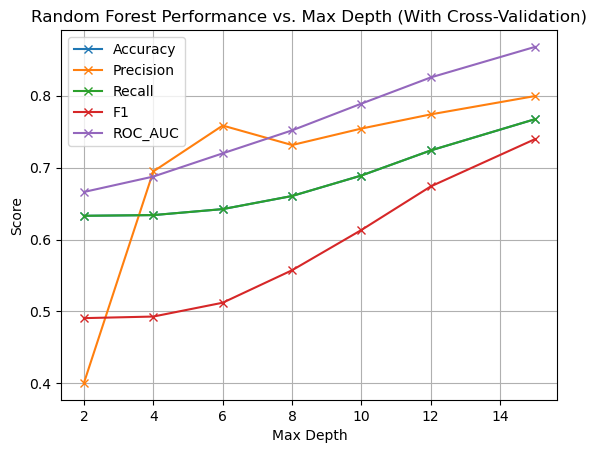

In [29]:
rf_cv_metrics = {
    "max_depth": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "ROC_AUC": []
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for depth in depths:
    my_RFC = RandomForestClassifier(max_depth=depth, random_state=42)

    acc = cross_val_score(my_RFC, X, y, cv=cv, scoring='accuracy')
    prec = cross_val_score(my_RFC, X, y, cv=cv, scoring='precision_weighted')
    rec = cross_val_score(my_RFC, X, y, cv=cv, scoring='recall_weighted')
    f1 = cross_val_score(my_RFC, X, y, cv=cv, scoring='f1_weighted')
    roc_auc = cross_val_score(my_RFC, X, y, cv=cv, scoring='roc_auc_ovr_weighted')

    rf_cv_metrics["max_depth"].append(depth)
    rf_cv_metrics["Accuracy"].append(acc.mean())
    rf_cv_metrics["Precision"].append(prec.mean())
    rf_cv_metrics["Recall"].append(rec.mean())
    rf_cv_metrics["F1"].append(f1.mean())
    rf_cv_metrics["ROC_AUC"].append(roc_auc.mean())

# Plot
plt.figure()
for metric in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
    plt.plot(rf_cv_metrics["max_depth"], rf_cv_metrics[metric], marker='x', label=metric)
plt.xlabel("Max Depth")
plt.xscale("linear")
plt.ylabel("Score")
plt.title("Random Forest Performance vs. Max Depth (With Cross-Validation)")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

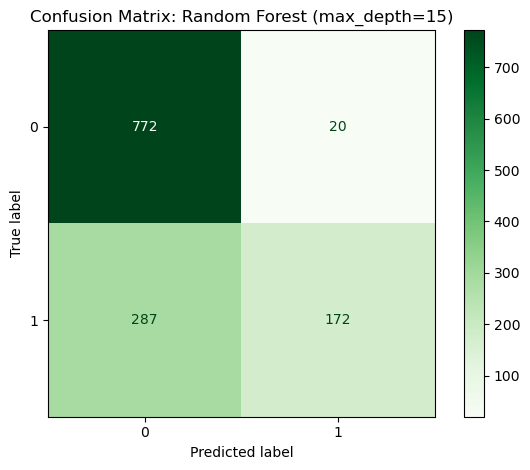

In [30]:
best_depth = 15
my_rf_best = RandomForestClassifier(max_depth=best_depth, random_state=42)
my_rf_best.fit(X_train, y_train)
y_pred_rf = my_rf_best.predict(X_test)

# --- Confusion Matrix for RF ---
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Greens")
plt.title(f"Confusion Matrix: Random Forest (max_depth={best_depth})")
plt.grid(False)
plt.tight_layout()
plt.show()

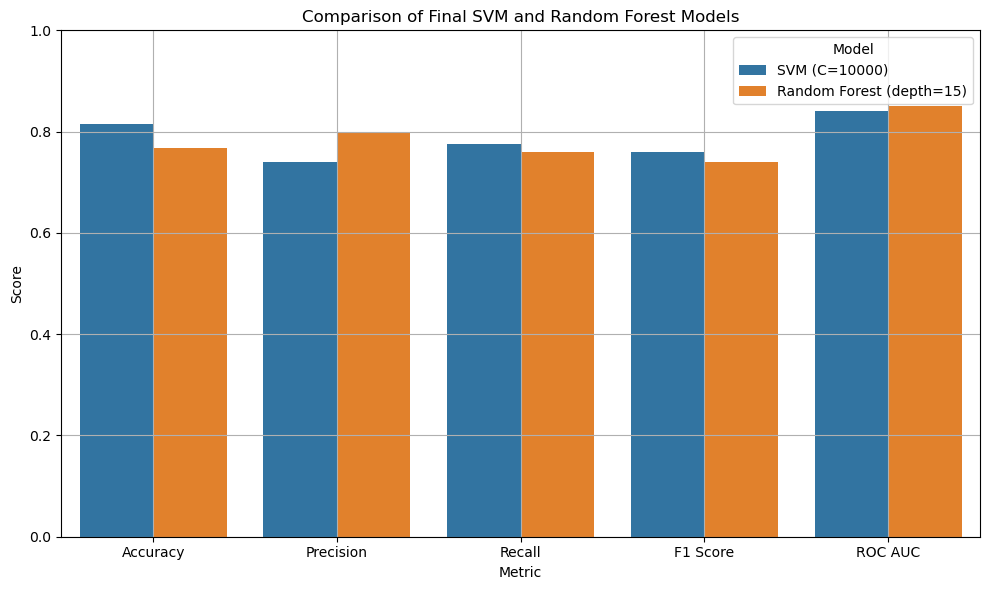

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Correct model performance dictionary
data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "SVM (C=10000)": [0.816, 0.740, 0.776, 0.760, 0.840],
    "Random Forest (depth=15)": [0.767, 0.800, 0.760, 0.740, 0.850]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Reshape for seaborn
df_melted = df.melt(id_vars="Metric", var_name="Model", value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model")
plt.title("Comparison of Final SVM and Random Forest Models")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd

# Create comparison table
summary_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"],
    "SVM (C=10000)": [0.816, 0.74, 0.776, 0.76, 0.84],
    "RF (depth=15)": [0.767, 0.80, 0.76, 0.74, 0.85]
}

df_summary = pd.DataFrame(summary_data)

# Display the table
print("Final Model Comparison Summary")
df_summary

Final Model Comparison Summary


,Metric,SVM (C=10000),RF (depth=15)
0,Accuracy,0.816,0.767
1,Precision,0.740,0.800
2,Recall,0.776,0.760
3,F1 Score,0.760,0.740
4,ROC AUC,0.840,0.850
